Network and Text Analysis of Global Recipe Data 
Data 620 - Data Analytics Final Project 

Recording: https://youtu.be/wrGt0y-268s

Introduction:

The goal of this project is to understand how cuisines differ both in the ingredients that characterize them and in the language people use when reviewing the recipes. To explore this, I applied network analysis to map patterns of ingredient co-occurrence across thousands of recipes, revealing how different cuisines are built from distinct clusters of flavors and components. I also used natural language processing to analyze more than a million user reviews, allowing me to measure sentiment, identify common themes in positive and negative feedback, and compare how people respond to recipes from different cultural traditions.

This project examines a large-scale dataset from Food.com containing more than half a million recipes and over a million user reviews. Using network analysis, I study how ingredients cluster within recipes and how those patterns differ by cuisine. Using natural language processing, I analyze user sentiment, extract dominant themes in positive and negative reviews, and compare how people talk about dishes from different culinary traditions. The combined approach provides both a structural and emotional view of global cuisine.

Data Overview

I used two CSV file. One that contained the data for recipes and the other that had reviews. Both datasets were very large. 

The recipes data had about 522,000 entries which included recipe ID, author, time fields, categories, keywords, nutritional information (calories,fat,etc) and ingredients. 

The second file was the reviews dataset and it contained over 1.4 million entries. This dataset also have various fields including the recipe ID, rating, the full text review and date the review was posted. 


Data Preparation

Original datasets were stored in R-style character vectors. I used a custom parser to convert stings into python lists. Once parsed, ingredients became usable nodes for network graphs, and tags became usable labels for grouping recipes by cuisine. 

In [56]:
!pip install pandas numpy networkx matplotlib
import pandas as pd
import numpy as np
import ast   # to turn stringified lists into real lists
import networkx as nx
import matplotlib.pyplot as plt
from itertools import combinations
from collections import Counter

recipes = pd.read_csv("/Users/leslietavarez/Downloads/recipes.csv")
reviews = pd.read_csv("/Users/leslietavarez/Downloads/reviews.csv")

recipes.head()
reviews.head()
recipes.info()
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 522517 entries, 0 to 522516
Data columns (total 28 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   RecipeId                    522517 non-null  int64  
 1   Name                        522517 non-null  object 
 2   AuthorId                    522517 non-null  int64  
 3   AuthorName                  522517 non-null  object 
 4   CookTime                    439972 non-null  object 
 5   PrepTime                    522517 non-null  object 
 6   TotalTime                   522517 non-null  object 
 7   DatePublished               522517 non-null  object 
 8   Description                 522512 non-null  object 
 9   Images                      522516 non-null  object 
 10  RecipeCategory              521766 non-null  object 
 11  Keywords                    505280 non-null  object 
 12  RecipeIngredientQuantities  522514 non-null  object 
 13  RecipeIngredie

In [57]:
recipes["RecipeIngredientParts"].head(10)

0    c("blueberries", "granulated sugar", "vanilla ...
1    c("saffron", "milk", "hot green chili peppers"...
2    c("sugar", "lemons, rind of", "lemon, zest of"...
3    c("extra firm tofu", "eggplant", "zucchini", "...
4    c("plain tomato juice", "cabbage", "onion", "c...
5    c("graham cracker crumbs", "sugar", "butter", ...
6    c("chicken", "butter", "flour", "milk", "celer...
7    c("sugar", "margarine", "egg", "flour", "salt"...
8                            c("rice vinegar", "haeo")
9    c("butter", "brown sugar", "granulated sugar",...
Name: RecipeIngredientParts, dtype: object

In [58]:
def parse_r_style_ingredients(x):
    if pd.isna(x):
        return []
    s = str(x).strip()
    # basic sanity check
    if not s.startswith("c("):
        return []
    # convert R-style c("a","b") to Python list ["a","b"]
    py_like = s.replace("c(", "[", 1)
    # replace only the last ")" -> "]"
    if py_like.endswith(")"):
        py_like = py_like[:-1] + "]"
    try:
        lst = ast.literal_eval(py_like)
    except (SyntaxError, ValueError):
        return []
    # clean up strings
    return [
        ing.strip().lower()
        for ing in lst
        if isinstance(ing, str) and ing.strip() != ""
    ]

recipes["ingredients_parsed"] = recipes["RecipeIngredientParts"].apply(parse_r_style_ingredients)
recipes[["RecipeId", "Name", "RecipeIngredientParts", "ingredients_parsed"]].head(10)

recipes['ingredients_parsed'].head(10)

0    [blueberries, granulated sugar, vanilla yogurt...
1    [saffron, milk, hot green chili peppers, onion...
2    [sugar, lemons, rind of, lemon, zest of, fresh...
3    [extra firm tofu, eggplant, zucchini, mushroom...
4    [plain tomato juice, cabbage, onion, carrots, ...
5    [graham cracker crumbs, sugar, butter, sugar, ...
6    [chicken, butter, flour, milk, celery, button ...
7    [sugar, margarine, egg, flour, salt, buttermil...
8                                 [rice vinegar, haeo]
9    [butter, brown sugar, granulated sugar, vanill...
Name: ingredients_parsed, dtype: object

In this section, I filtered the recipes to 3 or more ingredients because very simple recipes won't provide useful information to the ingredient network. 

I also used a small subset of the data to make things faster as I analyzed the data. 

The loop built all possible ingredient pairs for each recipe and counted how often each pair appears across the dataset. This gave us a table showing which ingredients commonly show up together, which becomes the foundation for the ingredient co-occurrence network I build later.

In [59]:
# keep recipes with at least 3 ingredients
recipes_small = recipes[recipes["ingredients_parsed"].str.len() >= 3].copy()

# using a smaller subset while developing
recipes_small = recipes_small.head(5000)
len(recipes_small)

pair_counts = Counter()

for ingr_list in recipes_small["ingredients_parsed"]:
    unique_ings = sorted(set(ingr_list))  # avoid duplicate ingredients within a recipe
    for a, b in combinations(unique_ings, 2):
        pair_counts[(a, b)] += 1

edges = (
    pd.DataFrame(
        [(a, b, w) for (a, b), w in pair_counts.items()],
        columns=["ingredient_a", "ingredient_b", "weight"]
    )
    .sort_values("weight", ascending=False)
)

edges.head(10)


ingredient_a ingredient_b  weight
465         salt        sugar     756
423       butter         salt     718
424       butter        sugar     549
168         eggs         salt     538
467         salt        water     532
523        flour         salt     529
592         eggs        sugar     498
905       pepper         salt     488
259         milk         salt     442
276        onion         salt     436

After counting ingredient pairs, we filtered the edges to keep only the stronger connections. Ingredients that appear together at least 50 times are more meaningful and help reduce noise in the graph. We then built a NetworkX graph using these filtered edges.

To make the visualization cleaner, we focused on the 50 ingredients with the highest degree (meaning they appear with many other ingredients). This subgraph shows the core “hub” ingredients in the dataset and how they’re connected. The spring layout helps spread the nodes out so we can see which ingredients tend to cluster together in real recipes.

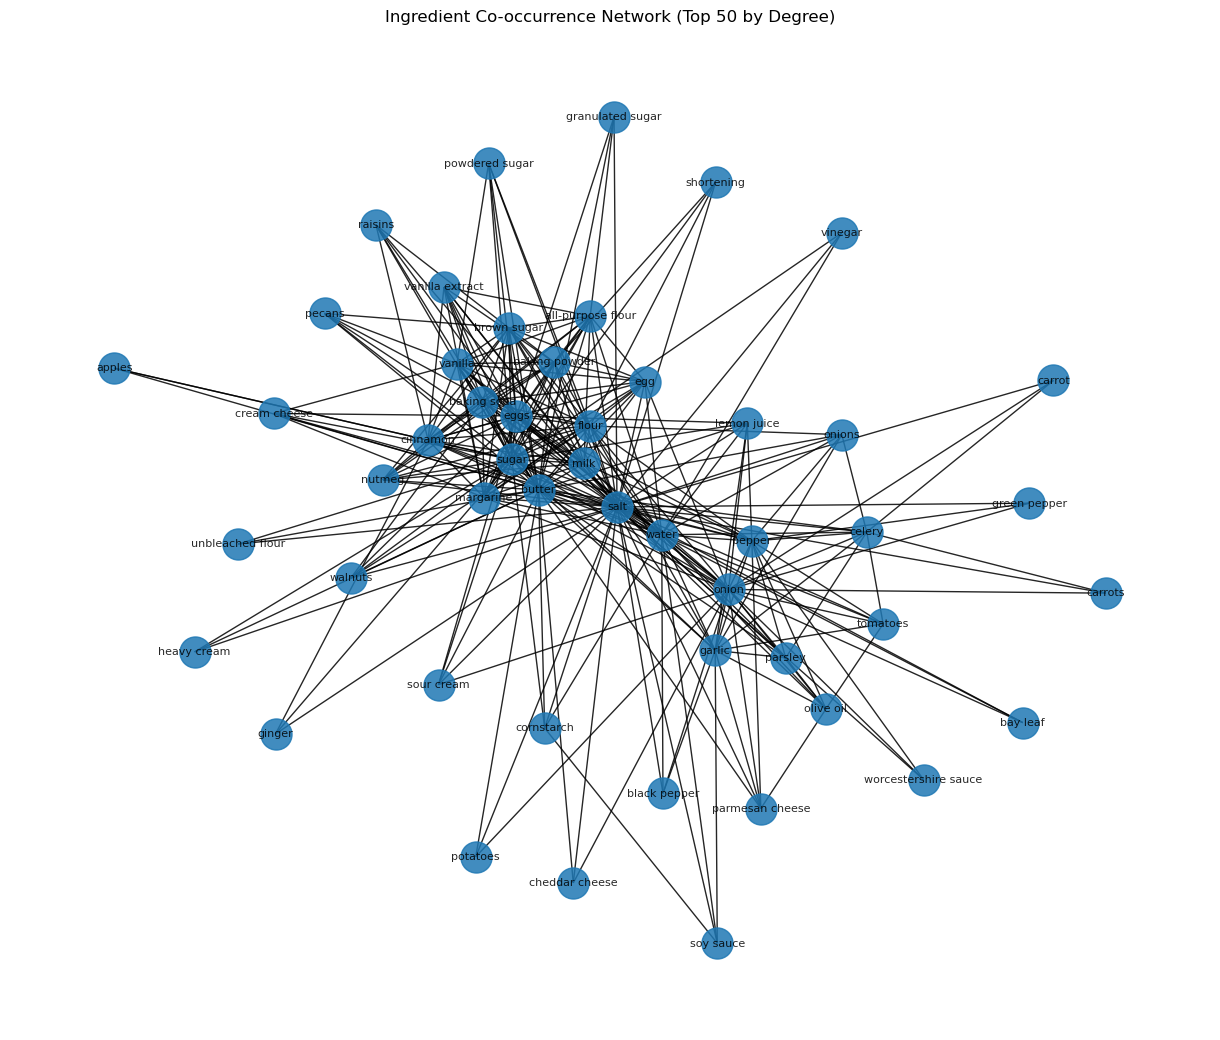

In [60]:
import networkx as nx

# filter to reasonably strong connections (you can tweak the threshold)
edges_filtered = edges[edges["weight"] >= 50].copy()

G = nx.Graph()

for _, row in edges_filtered.iterrows():
    G.add_edge(
        row["ingredient_a"],
        row["ingredient_b"],
        weight=row["weight"]
    )

G.number_of_nodes(), G.number_of_edges()

import matplotlib.pyplot as plt

# degree = how many neighbors each ingredient has
degree_dict = dict(G.degree())

# grab the 50 most connected ingredients
top_ingredients = sorted(degree_dict, key=degree_dict.get, reverse=True)[:50]

G_sub = G.subgraph(top_ingredients)

plt.figure(figsize=(12, 10))
pos = nx.spring_layout(G_sub, k=0.3, seed=42)

nx.draw(
    G_sub,
    pos,
    with_labels=True,
    node_size=500,
    font_size=8,
    alpha=0.85
)

plt.title("Ingredient Co-occurrence Network (Top 50 by Degree)")
plt.axis("off")
plt.show()


In this step I removed a set of universal pantry staples such as salt, pepper, flour, butter, milk, and basic sugar. These ingredients appear in nearly every recipe and overwhelm the network structure, making it difficult to identify meaningful ingredient relationships. Since I only filtered out the generic terms such as sugar, more specific variants like granulated sugar or brown sugar still appear. These are also common pantry items, but because they occur less uniformly across all recipes, they remained in the filtered network. If I wanted to remove all sugar-related ingredients completely, I would need to expand the filter list to include the specific ingredient names as well.

boring_ings = [
    "salt", "water", "sugar", "butter", "flour", "milk", 
    "pepper", "eggs", "onion", "oil", "olive oil"
]

G_filtered = G.copy()
G_filtered.remove_nodes_from([n for n in G.nodes if n in boring_ings])

G_filtered.number_of_nodes(), G_filtered.number_of_edges()

degree_dict = dict(G_filtered.degree())
top = sorted(degree_dict, key=degree_dict.get, reverse=True)[:50]

G_sub = G_filtered.subgraph(top)

plt.figure(figsize=(12,10))
pos = nx.spring_layout(G_sub, k=0.3, seed=42)

nx.draw(
    G_sub, pos,
    with_labels=True,
    node_size=500,
    font_size=8,
    alpha=0.85
)
plt.title("Ingredient Network Without Universal Ingredients")
plt.axis("off")
plt.show()

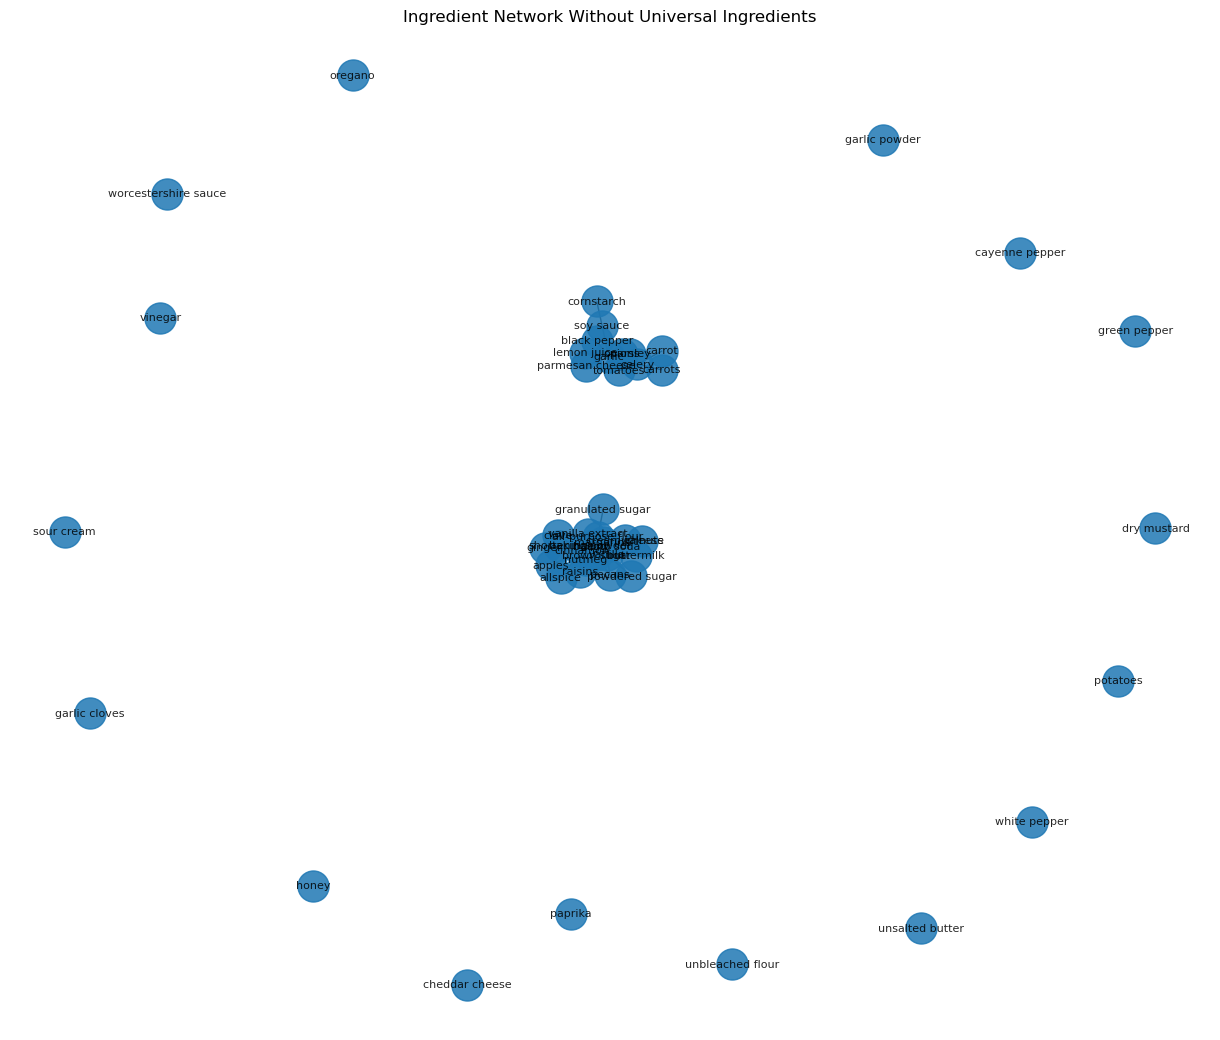

In [61]:
boring_ings = [
    "salt", "water", "sugar", "butter", "flour", "milk", 
    "pepper", "eggs", "onion", "oil", "olive oil"
]

G_filtered = G.copy()
G_filtered.remove_nodes_from([n for n in G.nodes if n in boring_ings])

G_filtered.number_of_nodes(), G_filtered.number_of_edges()

degree_dict = dict(G_filtered.degree())
top = sorted(degree_dict, key=degree_dict.get, reverse=True)[:50]

G_sub = G_filtered.subgraph(top)

plt.figure(figsize=(12,10))
pos = nx.spring_layout(G_sub, k=0.3, seed=42)

nx.draw(
    G_sub, pos,
    with_labels=True,
    node_size=500,
    font_size=8,
    alpha=0.85
)
plt.title("Ingredient Network Without Universal Ingredients")
plt.axis("off")
plt.show()



After removing the universal pantry ingredients, I ran the Louvain community detection algorithm to identify ingredient clusters. This allowed me to see whether certain ingredients naturally group together in the recipe dataset. The results show a clear core cluster of commonly paired ingredients along with several smaller clusters of more specialized items. Even the isolated nodes provide useful information by showing which ingredients do not frequently co-occur in the dataset.

/var/folders/q3/l6f_bh316bq8shd_rgz2s_240000gn/T/ipykernel_47458/2056084931.py:13: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



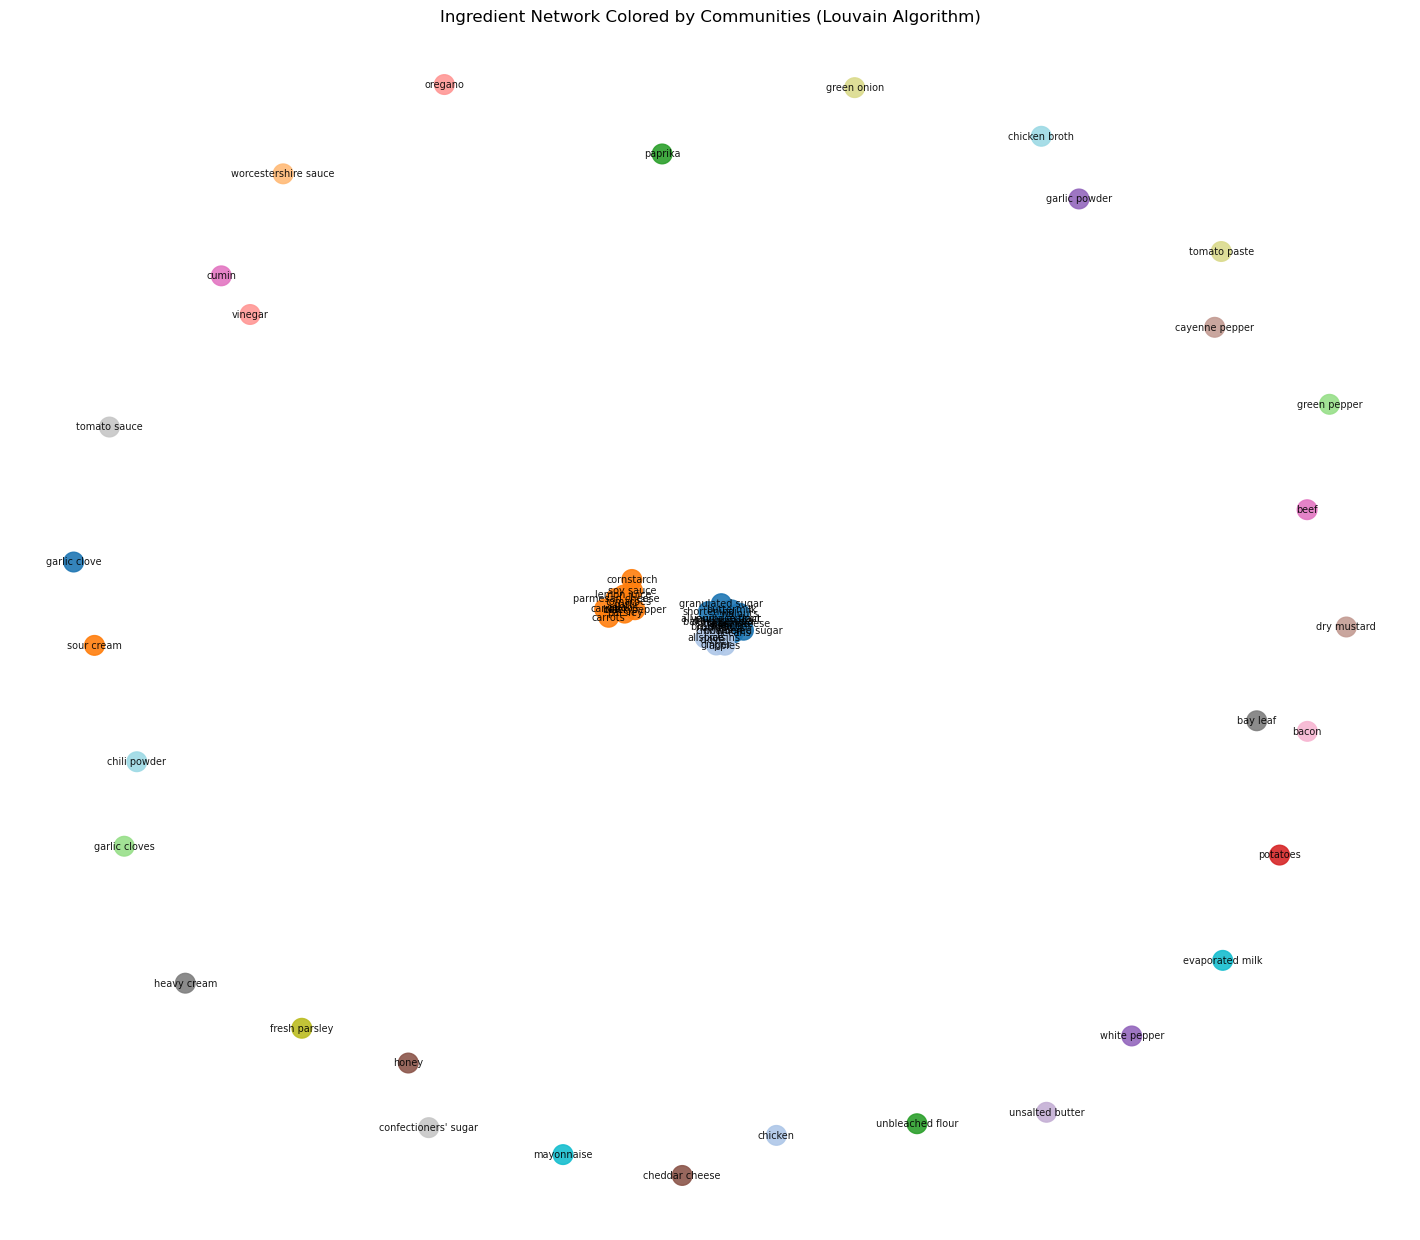

In [77]:
!pip install python-louvain
import community as community_louvain

partition = community_louvain.best_partition(G_filtered)

import matplotlib.cm as cm

plt.figure(figsize=(14, 12))
pos = nx.spring_layout(G_filtered, seed=42)

# Color by cluster ID
node_colors = [partition[n] for n in G_filtered.nodes]
cmap = cm.get_cmap("tab20")

nx.draw(
    G_filtered,
    pos,
    node_color=node_colors,
    cmap=cmap,
    node_size=200,
    alpha=0.9,
    with_labels=True,
    font_size=7
)

plt.title("Ingredient Network Colored by Communities (Louvain Algorithm)")
plt.axis("off")
plt.show()



In this part of the project, I built separate ingredient networks for different cuisines. I first made sure the tag list for each recipe was parsed correctly, then used a small helper function to filter recipes by a given cuisine name. I reused the same network builder as before, keeping only recipes with at least three ingredients and optionally removing very common pantry items so they don’t take over the graph.

I looped through a list of cuisine tags and created a co-occurrence network for each one, storing the networks along with basic counts. The printed summary shows how many recipes, nodes, and edges each cuisine network contains, which gives a sense of how dense each cuisine’s ingredient relationships are. The plotting function lets me pick a cuisine and visualize the top connected ingredients, showing the main clusters and ingredient patterns that characterize that cuisine.

mexican              | recipes: 12597 | nodes:  751 | edges: 9215
thai                 | recipes:  2162 | nodes:  523 | edges: 7070
asian                | recipes: 25378 | nodes:  921 | edges: 11729
chinese              | recipes:  3795 | nodes:  646 | edges: 7954
indian               | recipes:  5993 | nodes:  814 | edges: 13602
greek                | recipes:  3681 | nodes:  680 | edges: 7735
european             | recipes: 47022 | nodes:  922 | edges: 7329
spanish              | recipes:  1836 | nodes:  515 | edges: 3567
german               | recipes:  2332 | nodes:  498 | edges: 3052
japanese             | recipes:  1588 | nodes:  351 | edges: 2157


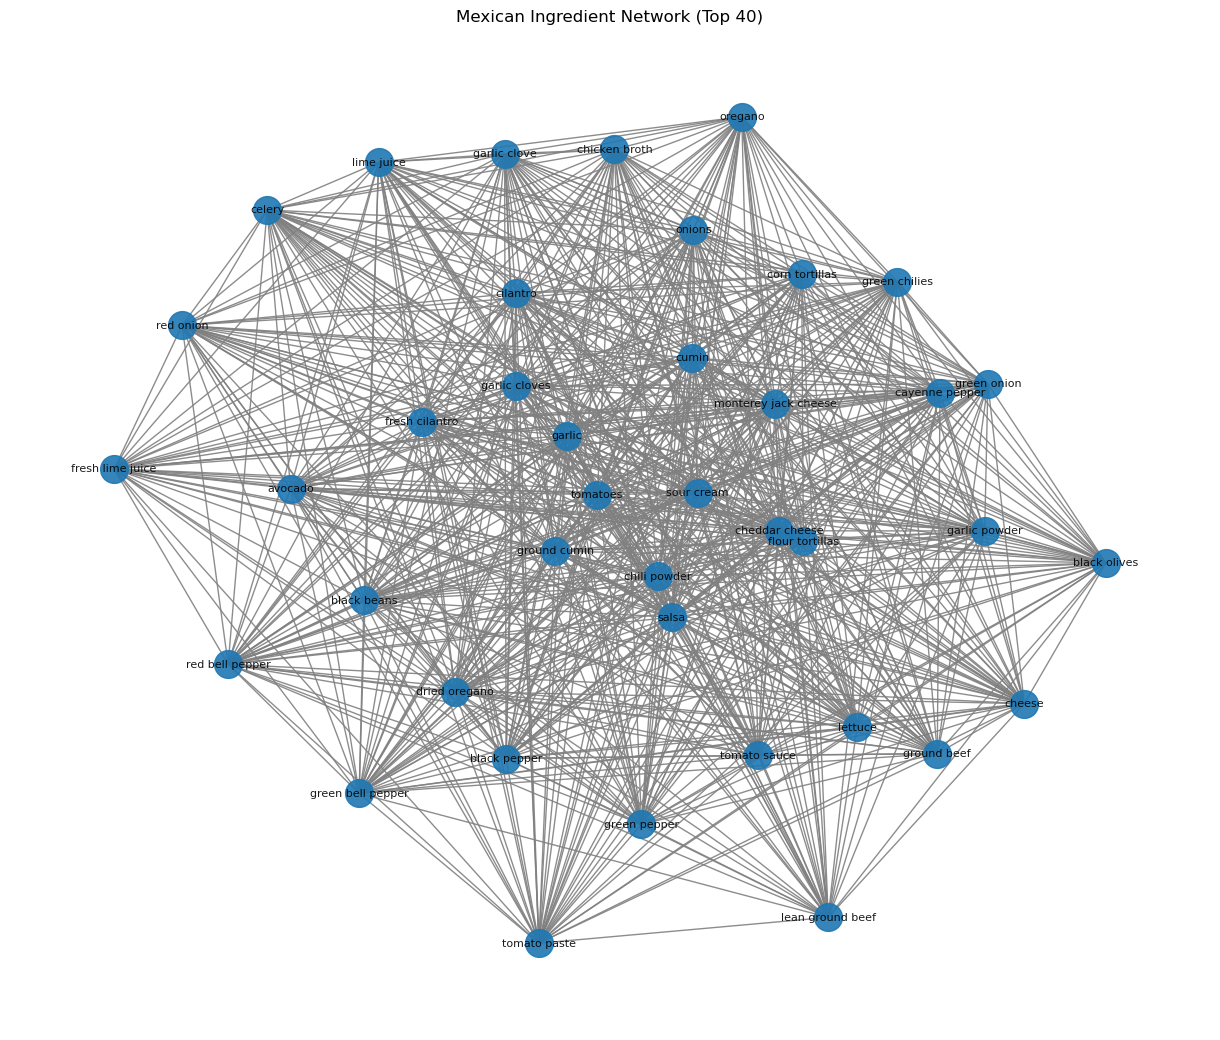

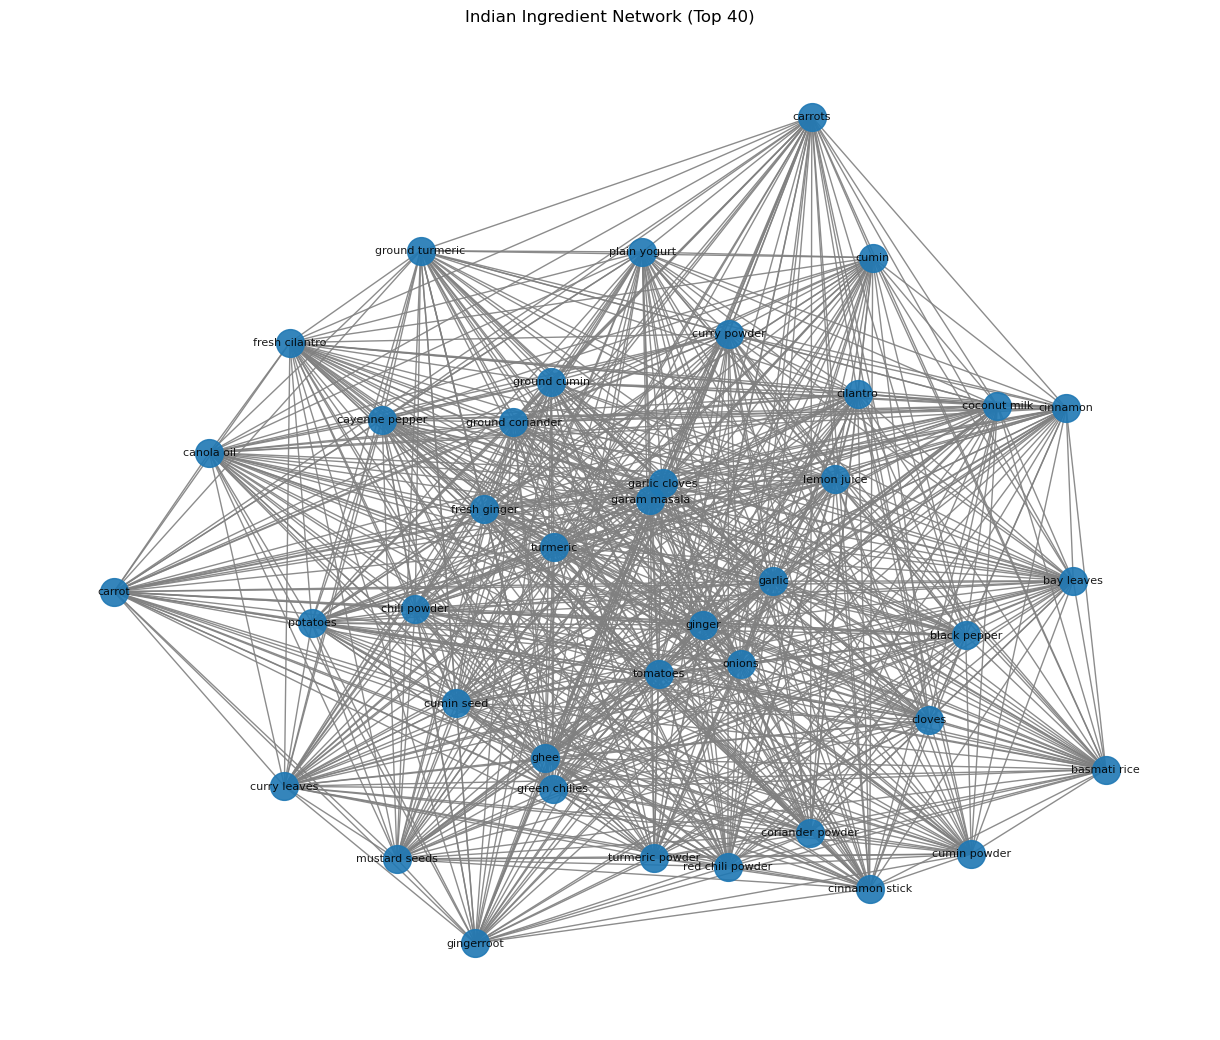

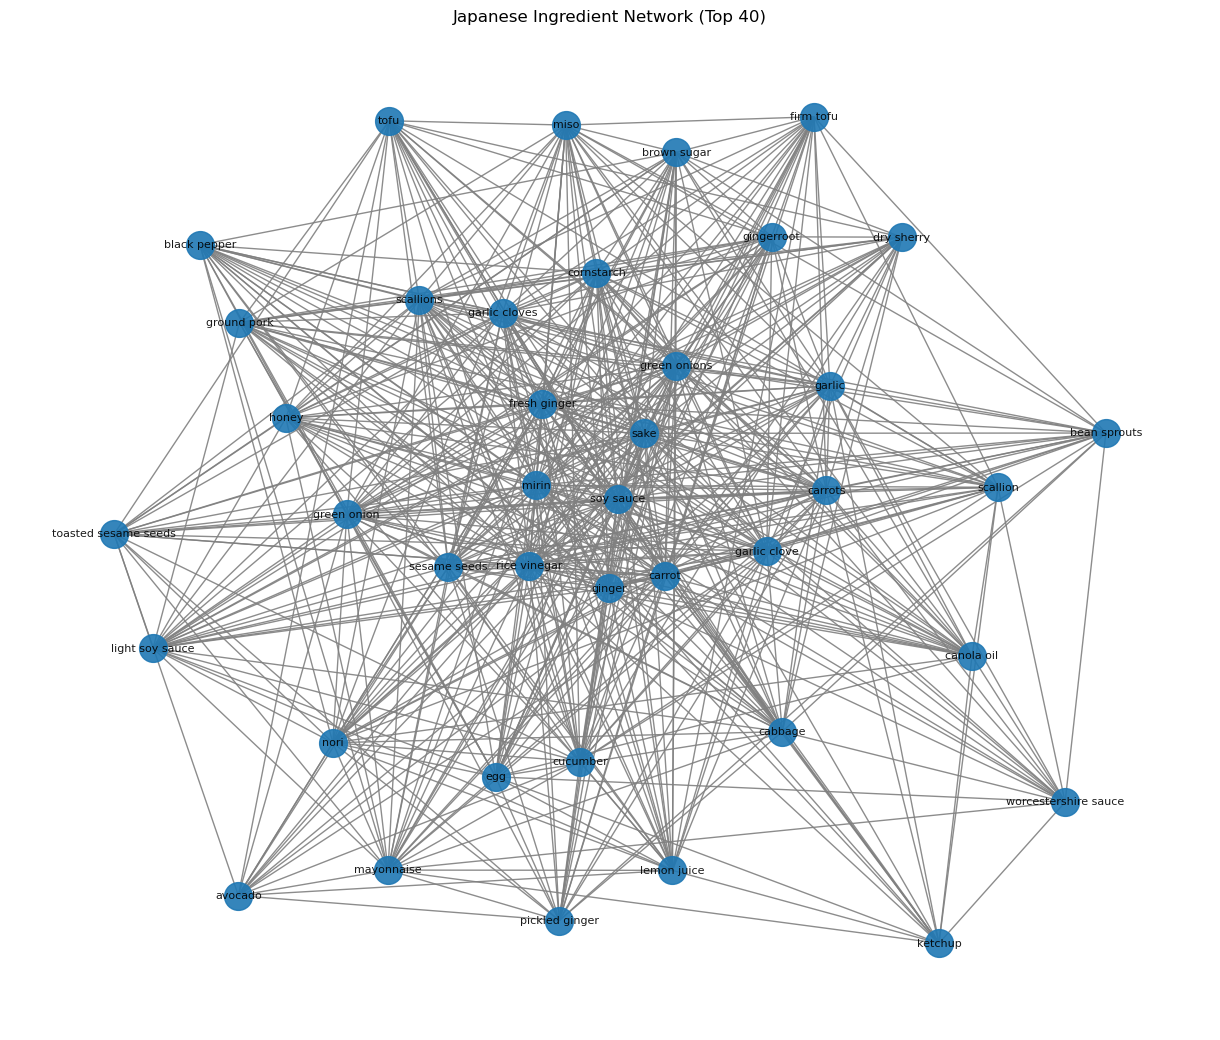

In [63]:
import ast
from itertools import combinations
from collections import Counter
import networkx as nx
import pandas as pd

# 1) Make sure tags_parsed exists (safe to re-run)
def parse_r_style_list(x):
    if pd.isna(x):
        return []
    s = str(x).strip()
    py_like = s.replace("c(", "[", 1)
    if py_like.endswith(")"):
        py_like = py_like[:-1] + "]"
    try:
        lst = ast.literal_eval(py_like)
    except (SyntaxError, ValueError):
        return []
    return [t.strip().lower() for t in lst if isinstance(t, str) and t.strip() != ""]

if "tags_parsed" not in recipes.columns:
    recipes["tags_parsed"] = recipes["Keywords"].apply(parse_r_style_list)

# 2) Helper to filter recipes by tag (cuisine / type)
def filter_by_tag(df, tag):
    tag = tag.lower()
    return df[df["tags_parsed"].apply(lambda tags: tag in tags)]

# 3) Ingredient network builder
boring_ings = [
    "salt", "water", "sugar", "butter", "flour", "milk",
    "pepper", "eggs", "onion", "oil", "olive oil"
]

def build_ingredient_network(df, min_cooccurrence=3, drop_globals=True, max_recipes=5000):
    """
    Build an undirected ingredient co-occurrence network from a recipes subset.
    Assumes df has a column 'ingredients_parsed' with a list of ingredients.
    """
    df = df[df["ingredients_parsed"].str.len() >= 3].copy()
    df = df.head(max_recipes)

    pair_counts = Counter()
    for ingr_list in df["ingredients_parsed"]:
        unique_ings = sorted(set(ingr_list))
        for a, b in combinations(unique_ings, 2):
            pair_counts[(a, b)] += 1

    edges = pd.DataFrame(
        [(a, b, w) for (a, b), w in pair_counts.items() if w >= min_cooccurrence],
        columns=["ingredient_a", "ingredient_b", "weight"]
    )

    G = nx.Graph()
    for _, row in edges.iterrows():
        G.add_edge(row["ingredient_a"], row["ingredient_b"], weight=row["weight"])

    if drop_globals:
        G.remove_nodes_from([n for n in G.nodes if n in boring_ings])

    return G, edges

# 4) List of cuisines to try
cuisine_tags = [
    "mexican",
    "italian",
    "thai",
    "asian",
    "chinese",
    "indian",
    "greek",
    "french",
    "european",
    "southern & soul food",
    "mediterranean",
    "spanish",
    "german",
    "japanese",
]

# 5) Build networks for each cuisine
cuisine_networks = {}

for tag in cuisine_tags:
    sub = filter_by_tag(recipes, tag)
    if len(sub) < 50:   # skip cuisines with very few recipes
        continue
    G_c, edges_c = build_ingredient_network(
        sub,
        min_cooccurrence=3,
        drop_globals=True,
        max_recipes=5000
    )
    cuisine_networks[tag] = {"graph": G_c, "edges": edges_c, "n_recipes": len(sub)}

# 6) Quick summary
for tag, info in cuisine_networks.items():
    G_c = info["graph"]
    print(
        f"{tag:20s} | recipes: {info['n_recipes']:5d} | "
        f"nodes: {G_c.number_of_nodes():4d} | edges: {G_c.number_of_edges():4d}"
    )


def plot_cuisine_network(tag, k_top=40):
    if tag not in cuisine_networks:
        print(f"No network found for '{tag}'.")
        return
    
    G_c = cuisine_networks[tag]["graph"]
    degree_dict = dict(G_c.degree())
    top_nodes = sorted(degree_dict, key=degree_dict.get, reverse=True)[:k_top]
    G_sub = G_c.subgraph(top_nodes)
    
    plt.figure(figsize=(12, 10))
    pos = nx.spring_layout(G_sub, seed=42)
    
    nx.draw(
        G_sub,
        pos,
        with_labels=True,
        node_size=400,
        font_size=8,
        alpha=0.9,
        edge_color="gray"
    )
    
    plt.title(f"{tag.capitalize()} Ingredient Network (Top {k_top})")
    plt.axis("off")
    plt.show()

plot_cuisine_network("mexican")
plot_cuisine_network("indian")
plot_cuisine_network("japanese")


Ingredient Networks Across Three Cuisines

After building ingredient co-occurrence networks for several cuisines, I focused on Mexican, Japanese, and Indian because each one produced a clear structure that reflects the way these cuisines are built.

The Mexican network forms strong clusters around peppers, tomatoes, cilantro, onions, and tortillas. These ingredients appear together so often that they anchor most of the graph. There are also smaller groups such as cheese, sour cream, and avocado that show up frequently in supporting roles. The overall pattern highlights the balance of heat, acidity, and freshness that shapes Mexican cooking.

The Japanese network looks very different. The center revolves around soy sauce, miso, mirin, rice vinegar, ginger, and green onions. These ingredients create a lighter and more umami-driven structure. A second group forms around tofu, sesame oil, sesame seeds, and mushrooms. Ingredients like pickled ginger and nori sit near the edges, appearing often but not universally. The layout captures the foundations of Japanese cooking, which depends on savory broths, fermented bases, and delicate aromatic elements.

The Indian network is the most dense of the three. A very tight core forms around cumin, coriander, turmeric, garlic, ginger, onion, and ghee. These appear together across a huge number of dishes. Around this core are small clusters such as coconut milk with cinnamon and cloves, or mustard seeds with curry leaves. Various spice blends and types of chiles branch out from the center. This structure reflects the layered spice profiles that define many Indian recipes.

Together, these networks show how different cuisines have their own ingredient signatures. Even though the graphs were built with the same method, each one naturally mirrors the flavor patterns of that cuisine. Mexican dishes lean on combinations of chiles and fresh ingredients, Japanese dishes rely on fermented seasonings and umami elements, and Indian dishes build depth through complex spice layering.

In [85]:
import ast
from collections import Counter
import pandas as pd
import plotly.express as px

def parse_r_style_list(x):
    if pd.isna(x):
        return []
    s = str(x).strip()
    py_like = s.replace("c(", "[", 1)
    if py_like.endswith(")"):
        py_like = py_like[:-1] + "]"
    try:
        lst = ast.literal_eval(py_like)
    except (SyntaxError, ValueError):
        return []
    return [t.strip().lower() for t in lst if isinstance(t, str) and t.strip() != ""]

if "tags_parsed" not in recipes.columns:
    recipes["tags_parsed"] = recipes["Keywords"].apply(parse_r_style_list)

def get_recipes_for_tag(df, tag):
    tag = tag.lower()
    return df[df["tags_parsed"].apply(lambda tags: tag in tags)]

def get_top_ingredients_for_cuisine(df, tag, n=25, min_recipes=50):
    sub = get_recipes_for_tag(df, tag)
    if len(sub) < min_recipes:
        return []
    counts = Counter()
    for ingr_list in sub["ingredients_parsed"]:
        counts.update(set(ingr_list))
    return [ing for ing, _ in counts.most_common(n)]

cuisine_tags = [
    "mexican", "italian", "indian", "japanese",
    "thai", "chinese", "greek", "french",
    "spanish", "german"
]

cuisine_to_ingredients = {}
for tag in cuisine_tags:
    top_ings = get_top_ingredients_for_cuisine(recipes, tag, n=50, min_recipes=400)
    if top_ings:
        cuisine_to_ingredients[tag] = top_ings

all_ingredients = sorted({ing for ings in cuisine_to_ingredients.values() for ing in ings})
all_cuisines = sorted(cuisine_to_ingredients.keys())

rows = []
for ing in all_ingredients:
    row = {"ingredient": ing}
    for c in all_cuisines:
        row[c] = 1 if ing in cuisine_to_ingredients[c] else 0
    rows.append(row)

mat = pd.DataFrame(rows)
mat["n_cuisines"] = mat[all_cuisines].sum(axis=1)
mat_filtered = mat[mat["n_cuisines"] >= 2].copy()
mat_filtered = mat_filtered.drop(columns=["n_cuisines"])

heat_data = mat_filtered.set_index("ingredient")[all_cuisines]

fig = px.imshow(
    heat_data,
    aspect="auto",
    color_continuous_scale="Blues"
)

fig.update_layout(
    xaxis_title="Cuisine",
    yaxis_title="Ingredient",
    coloraxis_colorbar_title="Present"
)

fig.show()



Top Ingredients by Degree Centrality for Each Cuisine

To better understand what drives the flavor profile of each cuisine, I calculated degree centrality for every ingredient within the cuisine-specific networks. Degree centrality shows how often an ingredient appears alongside others, which makes it a good indicator of how essential that ingredient is in recipe structure.

The bar charts highlight the ten most connected ingredients for each cuisine. The patterns match what we expect from real cooking. Asian and Chinese cuisines emphasize soy sauce, ginger, garlic, and green onions. Indian dishes center on spices like turmeric, cumin, garam masala, and coriander. Mediterranean cuisines rely heavily on tomatoes, olive oil, garlic, and herbs like oregano and parsley. Mexican cooking stands out with chili powder, cumin, cilantro, sour cream, and tomatoes. Even in cuisines with fewer recipes, the top ingredients align with classic staples.

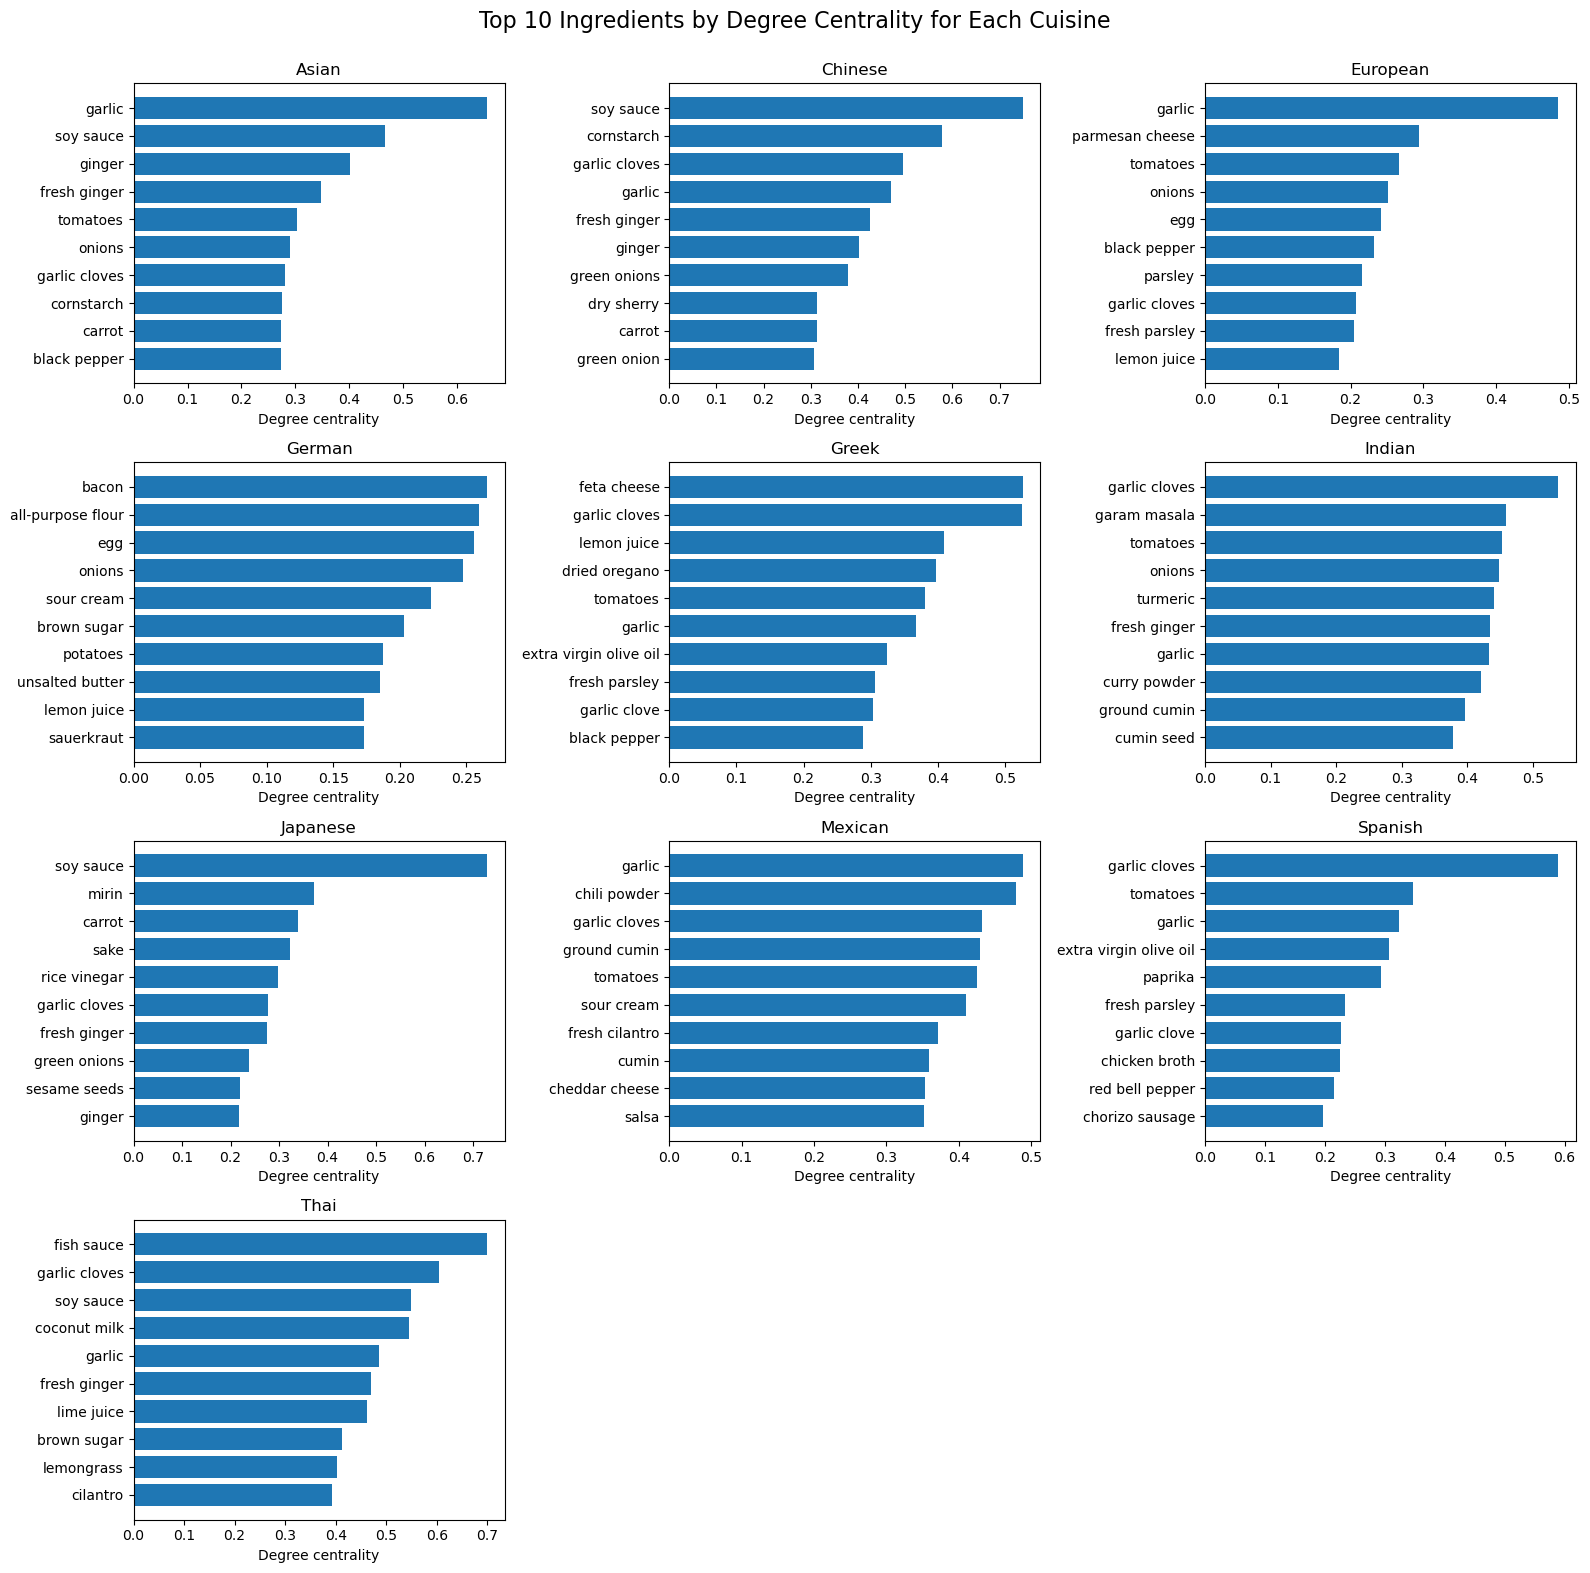

In [86]:
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import math

# build centrality DataFrame 
rows = []
for cuisine, info in cuisine_networks.items():
    G_c = info["graph"]
    deg = nx.degree_centrality(G_c)
    for ing, score in deg.items():
        rows.append({
            "cuisine": cuisine,
            "ingredient": ing,
            "degree_centrality": score
        })

cent_all = pd.DataFrame(rows)

# get unique cuisines
cuisines = sorted(cent_all["cuisine"].unique())

# layout for subplots
n = len(cuisines)
cols = 3  # number of charts per row, change if you want
rows = math.ceil(n / cols)

plt.figure(figsize=(16, rows * 4))

for i, cuisine in enumerate(cuisines, 1):
    top10 = (
        cent_all[cent_all["cuisine"] == cuisine]
        .sort_values("degree_centrality", ascending=False)
        .head(10)
        .sort_values("degree_centrality")
    )

    plt.subplot(rows, cols, i)
    plt.barh(top10["ingredient"], top10["degree_centrality"])
    plt.title(cuisine.capitalize())
    plt.xlabel("Degree centrality")
    plt.tight_layout()

plt.suptitle("Top 10 Ingredients by Degree Centrality for Each Cuisine", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

Average Review Sentiment by Cuisine 

For this part of the project, I analyzed text from user reviews and used VADER to estimate the emotional tone behind each comment. The goal was to see whether certain cuisines consistently receive more positive or negative feedback from home cooks.

The first step was identifying which recipes belonged to each cuisine by reading the keyword tags. Once reviews were merged with recipe tags, each review was assigned to one or more cuisines. VADER was then applied to the text, producing a compound sentiment score between –1 and 1 for every review.

After aggregating the scores, I calculated the average sentiment for each cuisine. The results show that nearly all cuisines receive generally positive feedback, but there are small differences. Greek and Spanish recipes have the highest average sentiment, while German, Chinese, and Japanese recipes fall slightly lower, though still positive. These differences are subtle, but they suggest that some cuisines inspire more enthusiastic responses than others. I also checked the number of reviews contributing to each average to make sure the comparisons were meaningful.

The final bar chart gives a simple visual comparison of average sentiment by cuisine.

Review columns: ['ReviewId', 'RecipeId', 'AuthorId', 'AuthorName', 'Rating', 'Review', 'DateSubmitted', 'DateModified', 'sentiment']

Average review sentiment by cuisine:
cuisines
greek       0.777590
spanish     0.775279
mexican     0.771721
thai        0.765519
indian      0.761396
german      0.754744
chinese     0.753470
japanese    0.753226
Name: sentiment, dtype: float64

Number of reviews per cuisine:
cuisines
mexican     47516
chinese     18181
greek       14572
indian      13282
german       8299
thai         5653
spanish      5002
japanese     4757
Name: count, dtype: int64


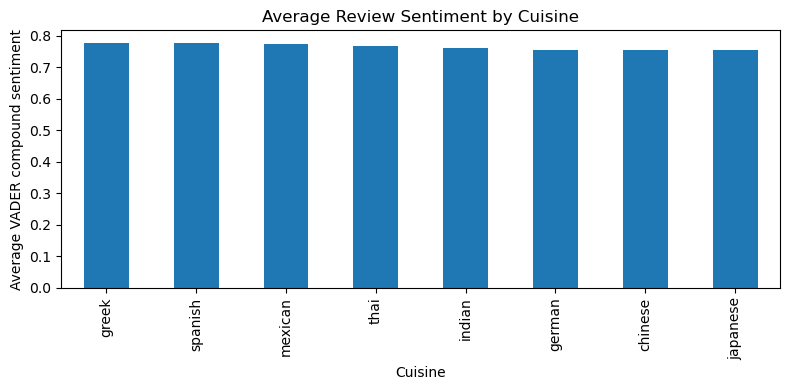

In [87]:
import ast
import pandas as pd
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt

print("Review columns:", reviews.columns.tolist())

# pick text column name
if "ReviewText" in reviews.columns:
    text_col = "ReviewText"
elif "Review" in reviews.columns:
    text_col = "Review"
else:
    raise ValueError("No obvious review text column found. Check reviews.columns.")

# pick rating column name (optional but nice to keep)
if "Rating" in reviews.columns:
    rating_col = "Rating"
elif "RatingValue" in reviews.columns:
    rating_col = "RatingValue"
else:
    rating_col = None  # not required for sentiment

def parse_r_style_list(x):
    if pd.isna(x):
        return []
    s = str(x).strip()
    py_like = s.replace("c(", "[", 1)
    if py_like.endswith(")"):
        py_like = py_like[:-1] + "]"
    try:
        lst = ast.literal_eval(py_like)
    except (SyntaxError, ValueError):
        return []
    return [t.strip().lower() for t in lst if isinstance(t, str) and t.strip() != ""]

if "tags_parsed" not in recipes.columns:
    recipes["tags_parsed"] = recipes["Keywords"].apply(parse_r_style_list)

cols_to_keep = ["RecipeId", text_col]
if rating_col is not None:
    cols_to_keep.append(rating_col)

reviews_nlp = reviews[cols_to_keep].dropna(subset=[text_col]).copy()

analyzer = SentimentIntensityAnalyzer()
reviews_nlp["sentiment"] = reviews_nlp[text_col].astype(str).apply(
    lambda t: analyzer.polarity_scores(t)["compound"]
)

recipes_tags = recipes[["RecipeId", "tags_parsed"]].copy()
reviews_merged = pd.merge(reviews_nlp, recipes_tags, on="RecipeId", how="inner")

cuisine_tags = [
    "mexican", "italian", "indian", "japanese",
    "thai", "chinese", "greek", "french",
    "spanish", "german"
]

reviews_merged["cuisines"] = reviews_merged["tags_parsed"].apply(
    lambda tags: [c for c in cuisine_tags if c in tags]
)

reviews_exploded = reviews_merged.explode("cuisines").dropna(subset=["cuisines"])

sentiment_by_cuisine = (
    reviews_exploded.groupby("cuisines")["sentiment"]
    .mean()
    .sort_values(ascending=False)
)

print("\nAverage review sentiment by cuisine:")
print(sentiment_by_cuisine)

counts_by_cuisine = reviews_exploded["cuisines"].value_counts()
print("\nNumber of reviews per cuisine:")
print(counts_by_cuisine)

plt.figure(figsize=(8, 4))
sentiment_by_cuisine.plot(kind="bar")
plt.ylabel("Average VADER compound sentiment")
plt.xlabel("Cuisine")
plt.title("Average Review Sentiment by Cuisine")
plt.tight_layout()
plt.show()


Sentiment Analysis

For this part of the project I used TF-IDF to see which words show up most often in very positive versus very negative reviews. I also made used the star ratings to help characterize a good review versus a bad review. After sampling an equal number of high rated and low rated reviews, I calculated the average TF-IDF score for every term for each group. The top positive terms mostly reflect satisfaction and ease, with words like added, easy make, excellent, enjoyed, yummy, fresh, and simple. These are the kinds of comments people leave when a recipe turns out well or feels straightforward to prepare. The appearance of ingredients like chicken, sauce, garlic, and cheese suggests that reviewers often mention what worked best or what they liked most.

The negative list looks very different. Words like try, sorry, bland, dry, tasted, sugar, and thought point to uncertainty and disappointment. People often describe what did not work or why a dish fell short. Neutral cooking terms like add, flavor, and taste appear in both lists, but their TF-IDF scores shift depending on whether they show up in problem-focused comments or praise. Overall, the contrast between the two sets of terms shows clear patterns in how people talk about good and bad cooking experiences, which helps explain the language behind recipe satisfaction.


In [88]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

# Choose correct text column
print("Review columns:", reviews.columns.tolist())
if "ReviewText" in reviews.columns:
    text_col = "ReviewText"
elif "Review" in reviews.columns:
    text_col = "Review"
else:
    raise ValueError("Review text column not found.")

# Keep only relevant columns
reviews_nlp = reviews[["RecipeId", text_col, "Rating"]].dropna(subset=[text_col, "Rating"]).copy()

# Convert rating to int if needed
reviews_nlp["Rating"] = reviews_nlp["Rating"].astype(int)

# Define positive and negative review sets
positive = reviews_nlp[reviews_nlp["Rating"] >= 4][text_col].astype(str).tolist()
negative = reviews_nlp[reviews_nlp["Rating"] <= 2][text_col].astype(str).tolist()

print(f"Total 4–5 star reviews: {len(positive)}")
print(f"Total 1–2 star reviews: {len(negative)}")

# SAMPLE for speed (balanced)
pos_sample = positive[:20000]
neg_sample = negative[:20000]

print(f"Using {len(pos_sample)} positive and {len(neg_sample)} negative reviews.")

# Custom stopwords (remove generic cooking verbs + filler)
custom_stopwords = {
    "recipe","recipes","make","made","making","use","used","using","good","great",
    "easy","delicious","wonderful","thanks","thank","love","loved","family","just",
    "really","like","time","minutes","followed","did","didn","don","does","came",
    "pretty","perfect","tasty","039","br","quot","little","lot"
}

# TF-IDF vectorizer
vectorizer = TfidfVectorizer(
    stop_words="english",
    lowercase=True,
    max_df=0.7,
    min_df=20,
    ngram_range=(1, 2),
    token_pattern=r"[a-zA-Z]{3,}"
)

# Fit on combined text so vocabulary is shared
all_texts = pos_sample + neg_sample
X = vectorizer.fit_transform(all_texts)
feature_names = vectorizer.get_feature_names_out()

# Remove custom stopwords
mask = [t not in custom_stopwords for t in feature_names]
filtered_features = feature_names[mask]
X = X[:, mask]

# Split matrix into pos/neg sections
X_pos = X[:len(pos_sample)]
X_neg = X[len(pos_sample):]

# Compute avg TF-IDF per term
pos_scores = X_pos.mean(axis=0).A1
neg_scores = X_neg.mean(axis=0).A1

pos_df = pd.DataFrame({"term": filtered_features, "score": pos_scores})
neg_df = pd.DataFrame({"term": filtered_features, "score": neg_scores})

# Top 30 distinctively positive terms
pos_top = pos_df.sort_values("score", ascending=False).head(30)

# Top 30 distinctively negative terms
neg_top = neg_df.sort_values("score", ascending=False).head(30)

print("\nMORE MEANINGFUL POSITIVE TERMS (rating-based):")
print(pos_top)

print("\nMORE MEANINGFUL NEGATIVE TERMS (rating-based):")
print(neg_top)


Review columns: ['ReviewId', 'RecipeId', 'AuthorId', 'AuthorName', 'Rating', 'Review', 'DateSubmitted', 'DateModified', 'sentiment']
Total 4–5 star reviews: 1241093
Total 1–2 star reviews: 110399
Using 20000 positive and 20000 negative reviews.

MORE MEANINGFUL POSITIVE TERMS (rating-based):
              term     score
65           added  0.016984
1661     easy make  0.014058
1505          dish  0.014000
4753         sauce  0.013510
796        chicken  0.012773
1790     excellent  0.012310
4880        served  0.011751
3729          nice  0.011062
1967        flavor  0.010730
5423         taste  0.010299
763         cheese  0.010291
6426         yummy  0.010200
2754       instead  0.010071
29             add  0.009980
2159        garlic  0.009838
387           best  0.009823
2414  great recipe  0.009499
2670       husband  0.008994
1740       enjoyed  0.008956
4952        simple  0.008747
5858           try  0.008696
1128         cream  0.008691
4721         salad  0.008689
4096       

In [89]:
import pandas as pd

# Make sure sentiment exists first
if "sentiment" not in reviews.columns:
    raise ValueError("You must compute review sentiment *before* running this section.")

# Merge recipes + reviews
merged = reviews.merge(
    recipes[["RecipeId", "tags_parsed"]],
    on="RecipeId",
    how="left"
)

# Keep only real cuisines (not dietary labels, not time labels)
valid_cuisines = {
    "mexican","chinese","indian","greek","japanese","thai",
    "french","italian","german","spanish","mediterranean",
    "asian","middle eastern","korean","american","latin american"
}

def extract_cuisines(tag_list):
    if isinstance(tag_list, list):
        return [t.lower() for t in tag_list if t.lower() in valid_cuisines]
    return []

merged["cuisines_manual"] = merged["tags_parsed"].apply(extract_cuisines)

# Keep only rows where at least one cuisine was found
merged = merged[merged["cuisines_manual"].apply(len) > 0].copy()

# Explode → one row per cuisine
reviews_exploded_manual = merged.explode("cuisines_manual")

print("Number of review–cuisine pairs:", len(reviews_exploded_manual))
print("Cuisines detected:", reviews_exploded_manual["cuisines_manual"].unique())


Number of review–cuisine pairs: 194152
Cuisines detected: ['chinese' 'asian' 'greek' 'indian' 'mexican' 'thai' 'german' 'japanese'
 'spanish' 'korean']


In [90]:
import pandas as pd
import ast
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# 1. Pick the review text column
print("Review columns:", reviews.columns.tolist())
if "ReviewText" in reviews.columns:
    text_col = "ReviewText"
elif "Review" in reviews.columns:
    text_col = "Review"
else:
    raise ValueError("Review text column not found. Expected 'ReviewText' or 'Review'.")

# 2. Make sure Rating is numeric
reviews = reviews.copy()
reviews["Rating"] = pd.to_numeric(reviews["Rating"], errors="coerce")

# 3. Compute sentiment directly into `reviews`
analyzer = SentimentIntensityAnalyzer()
reviews["sentiment"] = reviews[text_col].astype(str).fillna("").apply(
    lambda t: analyzer.polarity_scores(t)["compound"]
)

print("\nSentiment column added to `reviews`.")
print(reviews[["Rating", text_col, "sentiment"]].head())

# 4. Ensure tags_parsed exists in recipes
def parse_r_style_list(x):
    if pd.isna(x):
        return []
    s = str(x).strip()
    py_like = s.replace("c(", "[", 1)
    if py_like.endswith(")"):
        py_like = py_like[:-1] + "]"
    try:
        lst = ast.literal_eval(py_like)
    except Exception:
        return []
    return [t.strip().lower() for t in lst if isinstance(t, str) and t.strip()]

if "tags_parsed" not in recipes.columns:
    recipes = recipes.copy()
    recipes["tags_parsed"] = recipes["Keywords"].apply(parse_r_style_list)

# 5. Define a set of real cuisine tags
valid_cuisines = {
    "mexican", "chinese", "indian", "greek", "japanese", "thai",
    "french", "italian", "german", "spanish", "mediterranean",
    "asian", "middle eastern", "korean", "american", "latin american"
}

def extract_cuisines(tag_list):
    if isinstance(tag_list, list):
        return [t.lower() for t in tag_list if t.lower() in valid_cuisines]
    return []

# 6. Merge reviews with recipes and extract cuisines
merged = reviews.merge(
    recipes[["RecipeId", "tags_parsed"]],
    on="RecipeId",
    how="inner"
)

merged["cuisines_manual"] = merged["tags_parsed"].apply(extract_cuisines)

# keep only rows with at least one cuisine
merged = merged[merged["cuisines_manual"].apply(len) > 0].copy()

# 7. Explode: one row per (review, cuisine)
reviews_exploded_manual = merged.explode("cuisines_manual")

print("\nNumber of review–cuisine pairs:", len(reviews_exploded_manual))
print("Cuisines detected:", reviews_exploded_manual["cuisines_manual"].unique())

# 8. Average rating and sentiment by cuisine
avg_rating_by_cuisine = (
    reviews_exploded_manual.groupby("cuisines_manual")["Rating"]
    .mean()
    .sort_values()
)

avg_sentiment_by_cuisine = (
    reviews_exploded_manual.groupby("cuisines_manual")["sentiment"]
    .mean()
    .sort_values()
)

print("\nAverage rating by cuisine:")
print(avg_rating_by_cuisine)

print("\nAverage sentiment by cuisine:")
print(avg_sentiment_by_cuisine)


Review columns: ['ReviewId', 'RecipeId', 'AuthorId', 'AuthorName', 'Rating', 'Review', 'DateSubmitted', 'DateModified', 'sentiment']

Sentiment column added to `reviews`.
   Rating                                             Review  sentiment
0       5       better than any you can get at a restaurant!     0.4926
1       4  I cut back on the mayo, and made up the differ...    -0.2732
2       2  i think i did something wrong because i could ...    -0.4767
3       5  easily the best i have ever had.  juicy flavor...     0.8398
4       5                                 An excellent dish.     0.5719

Number of review–cuisine pairs: 194152
Cuisines detected: ['chinese' 'asian' 'greek' 'indian' 'mexican' 'thai' 'german' 'japanese'
 'spanish' 'korean']

Average rating by cuisine:
cuisines_manual
german      4.346061
chinese     4.360367
indian      4.361563
japanese    4.364936
asian       4.377574
thai        4.393596
korean      4.439040
mexican     4.461911
spanish     4.476714
greek      

/var/folders/q3/l6f_bh316bq8shd_rgz2s_240000gn/T/ipykernel_47458/2108259935.py:17: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.

/var/folders/q3/l6f_bh316bq8shd_rgz2s_240000gn/T/ipykernel_47458/2108259935.py:19: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.

/var/folders/q3/l6f_bh316bq8shd_rgz2s_240000gn/T/ipykernel_47458/2108259935.py:43: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



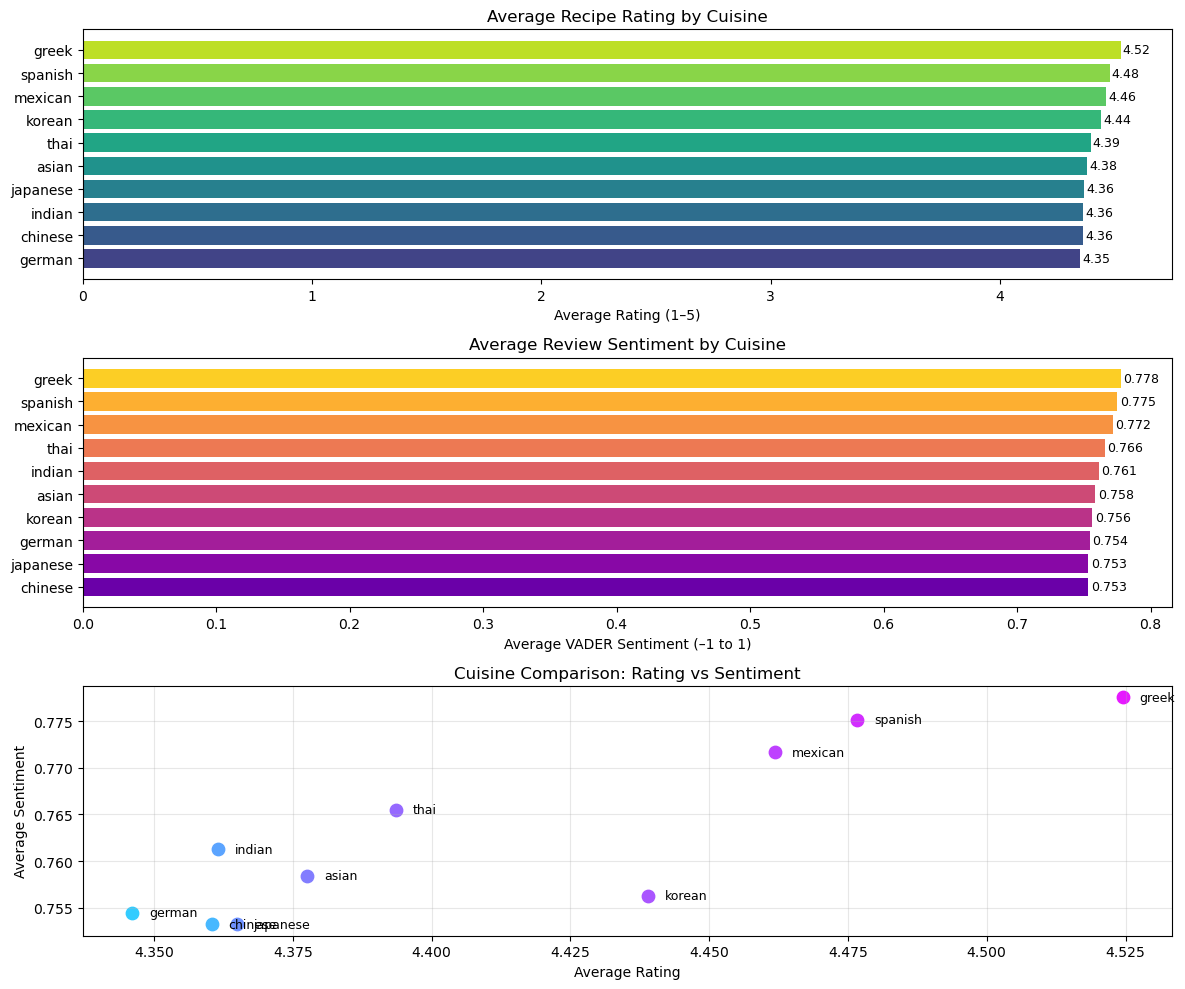

In [91]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Put both metrics into one DataFrame
metrics = pd.DataFrame({
    "avg_rating": avg_rating_by_cuisine,
    "avg_sentiment": avg_sentiment_by_cuisine
})

# make sure cuisines are in the same order
metrics = metrics.sort_values("avg_rating")

cuisines = metrics.index.tolist()

# choose some colors
cmap = plt.cm.get_cmap("viridis")
colors_rating = cmap(np.linspace(0.2, 0.9, len(cuisines)))
colors_sent = plt.cm.get_cmap("plasma")(np.linspace(0.2, 0.9, len(cuisines)))

plt.figure(figsize=(12, 10))

# 1. Bar chart – average rating by cuisine
plt.subplot(3, 1, 1)
plt.barh(cuisines, metrics["avg_rating"], color=colors_rating)
plt.xlabel("Average Rating (1–5)")
plt.title("Average Recipe Rating by Cuisine")
for i, v in enumerate(metrics["avg_rating"]):
    plt.text(v + 0.01, i, f"{v:.2f}", va="center", fontsize=9)

# 2. Bar chart – average sentiment by cuisine
metrics_sent = metrics.sort_values("avg_sentiment")
cuisines_sent = metrics_sent.index.tolist()
plt.subplot(3, 1, 2)
plt.barh(cuisines_sent, metrics_sent["avg_sentiment"], color=colors_sent)
plt.xlabel("Average VADER Sentiment (–1 to 1)")
plt.title("Average Review Sentiment by Cuisine")
for i, v in enumerate(metrics_sent["avg_sentiment"]):
    plt.text(v + 0.002, i, f"{v:.3f}", va="center", fontsize=9)

# 3. Scatter – rating vs sentiment
plt.subplot(3, 1, 3)
scatter_colors = plt.cm.get_cmap("cool")(np.linspace(0.2, 0.9, len(cuisines)))
for i, cuisine in enumerate(cuisines):
    x = metrics.loc[cuisine, "avg_rating"]
    y = metrics.loc[cuisine, "avg_sentiment"]
    plt.scatter(x, y, s=80, color=scatter_colors[i])
    plt.text(x + 0.003, y, cuisine, fontsize=9, va="center")

plt.xlabel("Average Rating")
plt.ylabel("Average Sentiment")
plt.title("Cuisine Comparison: Rating vs Sentiment")
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()


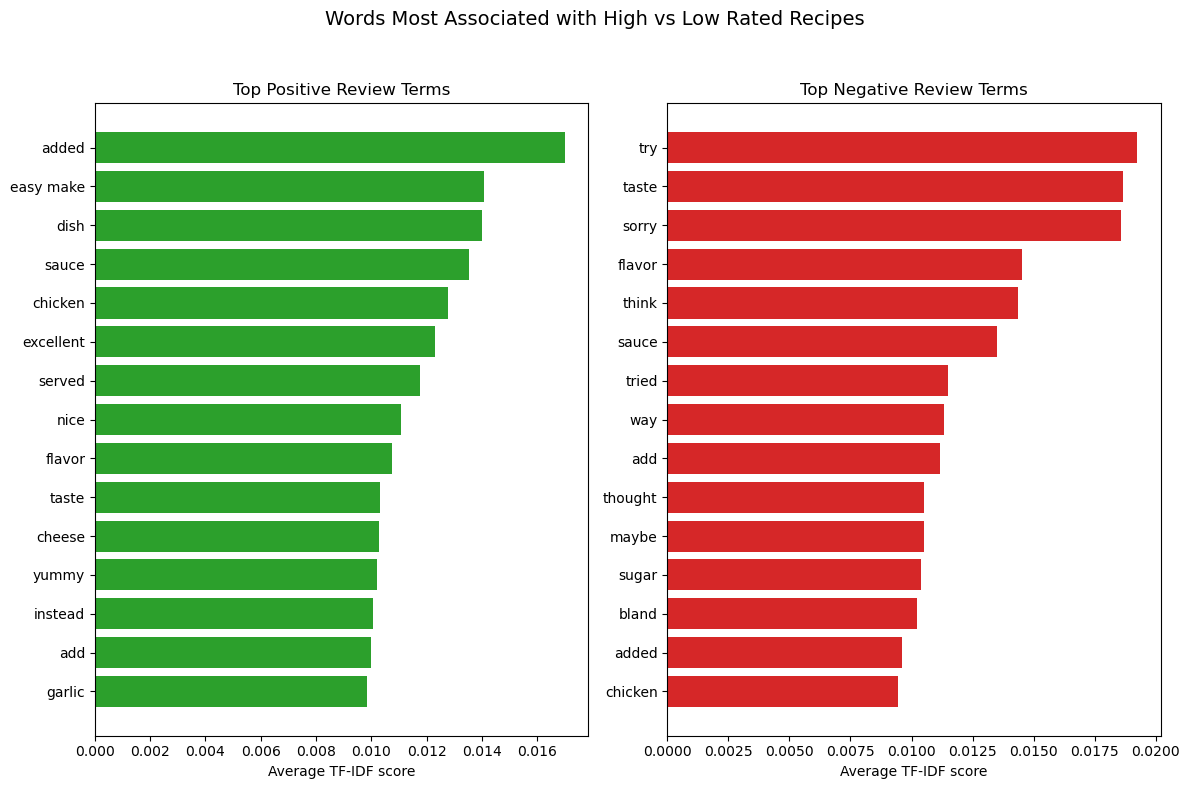

In [92]:
import matplotlib.pyplot as plt

# take top 15 positive and negative terms (you already have pos_top, neg_top)
top_pos = pos_top.head(15).iloc[::-1]  # reverse for better barh ordering
top_neg = neg_top.head(15).iloc[::-1]

plt.figure(figsize=(12, 8))

# 1. Positive terms
plt.subplot(1, 2, 1)
plt.barh(top_pos["term"], top_pos["score"], color="#2ca02c")  # green-ish
plt.title("Top Positive Review Terms")
plt.xlabel("Average TF-IDF score")
plt.tight_layout()

# 2. Negative terms
plt.subplot(1, 2, 2)
plt.barh(top_neg["term"], top_neg["score"], color="#d62728")  # red-ish
plt.title("Top Negative Review Terms")
plt.xlabel("Average TF-IDF score")
plt.tight_layout()

plt.suptitle("Words Most Associated with High vs Low Rated Recipes", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


The cuisine-level results show that reviewers are very positive overall, but there are still small, consistent differences across cuisines. Average star ratings for all cuisines sit above 4.3 out of 5, and the VADER sentiment scores all fall in a fairly narrow positive band around 0.75. Greek and Spanish recipes stand out with the highest ratings and the most positive sentiment, followed closely by Mexican and Thai. At the lower end, German, Chinese, and Japanese recipes have slightly lower average ratings and sentiment scores, though they are still clearly positive, which means most people are satisfied even when they are a bit more reserved in how they write about those dishes.

The scatter plot combining average rating and average sentiment shows that cuisines with higher ratings also tend to use more positive language in their reviews. The points cluster around a gentle upward trend: as the average rating goes up, the average sentiment score also increases. This suggests that the numerical ratings and the text sentiment are telling a consistent story about user experience. Taken together with the earlier TF-IDF word analysis (which showed different vocabularies in high-rated and low-rated reviews), the sentiment results reinforce the idea that both what people say and how they score a recipe are aligned. High-rated cuisines attract more enthusiastic language, while lower-rated cuisines see more neutral or slightly critical wording, even though the overall tone across the platform remains generally positive.

Conclusion

This project brought together network analysis and natural language processing to better understand how recipes are built and how people respond to them. The ingredient networks showed clear structural patterns across cuisines, revealing which ingredients serve as the core of each cooking style and where different cuisines overlap. The sentiment and TF-IDF analyses added another layer by highlighting how reviewers talk about the recipes they cook, what they praise, and what tends to cause disappointment. Together, these methods gave insight into both the composition of recipes and the experiences of the people making them.

My original goal was to build a fully functioning meal-recommendation system that could suggest recipes based on ingredients available at major grocery stores. Working through this project made it clear that reaching that level requires several additional steps. Ingredient data would need to be standardized, matched to real store inventory, and linked to nutritional information. A recommendation engine would also need user-level modeling or similarity measures between recipes. The current dataset includes challenges such as noisy tags, inconsistent ingredient formatting, and reviews with highly variable detail, all of which would need further cleaning and structure.

Even with these limitations, this project creates a strong starting point. It identifies meaningful ingredient patterns, shows how reviewers express satisfaction, and demonstrates how data science tools can be applied to food data in practical and interesting ways. With more refinement and additional modeling, the work here could be extended into the kind of grocery-based recommendation system I originally hoped to build.

